# Cyclists Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
from unidecode import unidecode

In [3]:
cyclists = pd.read_csv("../data/cyclists.csv")

In [4]:
dataset = pd.read_csv("../data/races.csv")
dataset.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


## Syntactic and Semantic accuracies analysis

In questa sezione verifichiamo informazioni generiche sui nostri dati. Abbiamo studiato il tipo degli attributi, verificato come questi tipi possano essere cambiati qualora non sinao idonei al dominio degli attributi e abbiamo verificato che i valori non NaN presenti nel dataset risultino all'interno dei rispettivi domini

In [5]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

In [6]:
# For each record, check if 'length' has .0 at the end. If not prints the value
counter = 0
for index, row in dataset.iterrows():
    if not pd.isnull(row['length']):
        if counter > 4: break
        if not str(row['length']).endswith('.0'):
            print(row['_url'], row['length'])
            counter += 1

tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004


In [7]:
# lenght è logicamente un intero
dataset['length'] = dataset[dataset['length'].notnull()]['length'].astype(int)

In [8]:
# For each record, check if 'climb_total' has .0 at the end.
counter = 0
for index, row in dataset.iterrows():
    if not pd.isnull(row['climb_total']):
        if not str(row['climb_total']).endswith('.0'):
            counter += 1
if counter == 0: print("All value are castable to integer")

All value are castable to integer


In [9]:
# climb_total è logicamente un intero
dataset['climb_total'] = dataset[dataset['climb_total'].notnull()]['climb_total'].astype(int)

In [10]:
dataset[dataset['profile'].notnull()].groupby('profile')['profile'].value_counts()

profile
1.0    131344
2.0    128269
3.0     50844
4.0     43011
5.0     88203
Name: count, dtype: int64

In [11]:
# 'profile' is clearly a categorical attribute, so we change its type
dataset['profile'] = dataset['profile'].astype('category')

In [12]:
dataset['profile']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
589860    1.0
589861    1.0
589862    1.0
589863    1.0
589864    1.0
Name: profile, Length: 589865, dtype: category
Categories (5, float64): [1.0, 2.0, 3.0, 4.0, 5.0]

In [13]:
dataset[dataset['name'].notnull()].groupby('name')['name'].value_counts()

name
Amstel Gold Race                       4349
Clasica Ciclista San Sebastian         3884
Clásica Ciclista San Sebastian           84
Clásica Ciclista San Sebastián          236
Clásica San Sebastián                    52
                                      ...  
Vuelta Ciclista al País Vasco          6529
Vuelta a España                       89222
Vuelta al País Vasco                   7206
World Championships - Road Race        1611
World Championships ME - Road Race     2306
Name: count, Length: 61, dtype: int64

In [16]:
dataset['name'] = dataset['name'].apply(unidecode)
dataset['name'] = dataset['name'].astype('category')
dataset['name'] = dataset['name'].cat.rename_categories({'Clasica Ciclista San Sebastian':'Clasica San Sebastian',})

In [20]:
dataset[dataset['name'].notnull()].groupby('name')['name'].count()

/tmp/ipykernel_27854/764801615.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[dataset['name'].notnull()].groupby('name')['name'].count()


name
Amstel Gold Race                                     4349
Clasica San Sebastian                                4256
Criterium du Dauphine                               16119
Criterium du Dauphine Libere                        10558
Donostia San Sebastian Klasikoa                       254
Dwars door Belgie / A travers la Belgique             519
Dwars door Vlaanderen                                1013
Dwars door Vlaanderen - A travers la Flandre ME       641
Dwars door Vlaanderen / A travers la Flandre          321
Dwars door Vlaanderen / A travers la Flandre ME       162
E3 BinckBank Classic                                   99
E3 Harelbeke                                          342
E3 Prijs Vlaanderen                                   875
E3 Prijs Vlaanderen - Harelbeke                        98
E3 Saxo Bank Classic                                  212
E3 Saxo Classic                                       101
E3-Prijs Harelbeke                                   1353
Giro d'It

In [93]:
dataset[dataset['points'].notnull()].groupby('points')['points'].value_counts()

points
18.0        292
20.0        792
30.0       4313
35.0        183
50.0     186102
70.0       3299
75.0       1963
80.0     198878
100.0    141706
125.0      5992
150.0       116
225.0     19536
275.0     22299
350.0      3917
Name: count, dtype: int64

In [57]:
dataset[dataset['uci_points'].notnull()].groupby('uci_points')['uci_points'].value_counts()

uci_points
6.0      43390
10.0       148
14.0       792
16.0     41103
20.0     21303
40.0      4102
50.0     13266
60.0     39317
80.0       328
100.0    47640
120.0    20785
180.0     3103
200.0      338
210.0     3449
300.0     2057
400.0     2571
402.0      109
500.0     6096
600.0      675
800.0      514
Name: count, dtype: int64

In [55]:
dataset.describe()

,points,uci_points,length,climb_total,startlist_quality,average_temperature,position,cyclist_age,delta
count,589388.000000,251086.000000,589865.000000,442820.000000,589865.000000,29933.000000,589865.000000,589752.000000,589865.000000
mean,89.221635,74.601547,166776.180584,2330.469215,1101.161178,21.731768,74.219491,28.486208,418.292794
std,54.435330,100.947962,64545.605664,1375.710722,380.586928,5.884761,48.404023,3.855631,842.961596
min,18.000000,6.000000,1000.000000,2.000000,115.000000,10.000000,0.000000,13.000000,-6906.000000
25%,50.000000,16.000000,152500.000000,1309.000000,844.000000,17.000000,32.000000,26.000000,10.000000
50%,80.000000,60.000000,178200.000000,2255.000000,988.000000,22.000000,70.000000,28.000000,156.000000
75%,100.000000,100.000000,203500.000000,3273.000000,1309.000000,26.000000,112.000000,31.000000,624.000000
max,350.000000,800.000000,338000.000000,6974.000000,2047.000000,36.000000,209.000000,56.000000,61547.000000


In [19]:
print(f'Number of duplicates: {len(dataset)-len(dataset.drop_duplicates())}')

Number of duplicates: 0


## Data-Balance Analysis 

In questa sezione studiamo il bilanciamento e la rappresentazione dei vari attributi del dataset

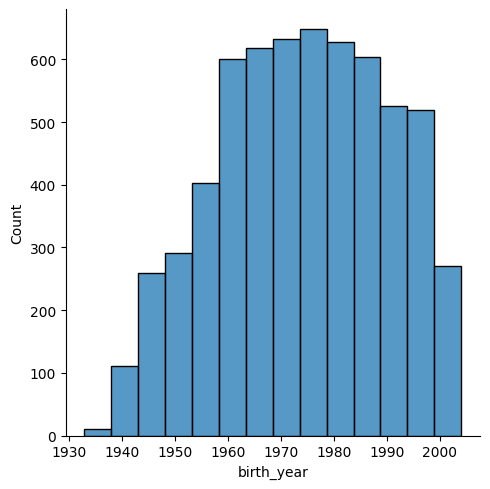

In [20]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)

sb.displot(dataset, 
                x="birth_year", 
                kind="hist",
                row_order="desc",
                bins=n_bins) #TODO: cambia nome dell'asse x

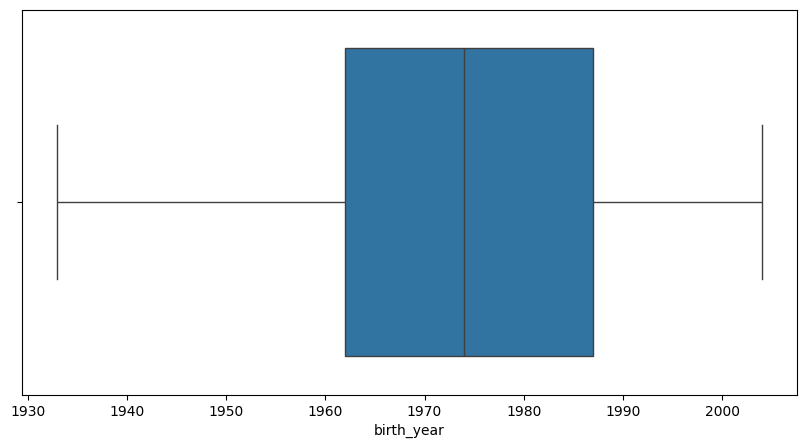

In [21]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='birth_year', data=dataset)
plt.show()

Anni di nascista dell'ultimo secolo, valori nei range che ci possiamo aspettare.
I ciclisti con maggiore rappresentanza sono quelli nati prima del 2000 a partire dagli anni 60.

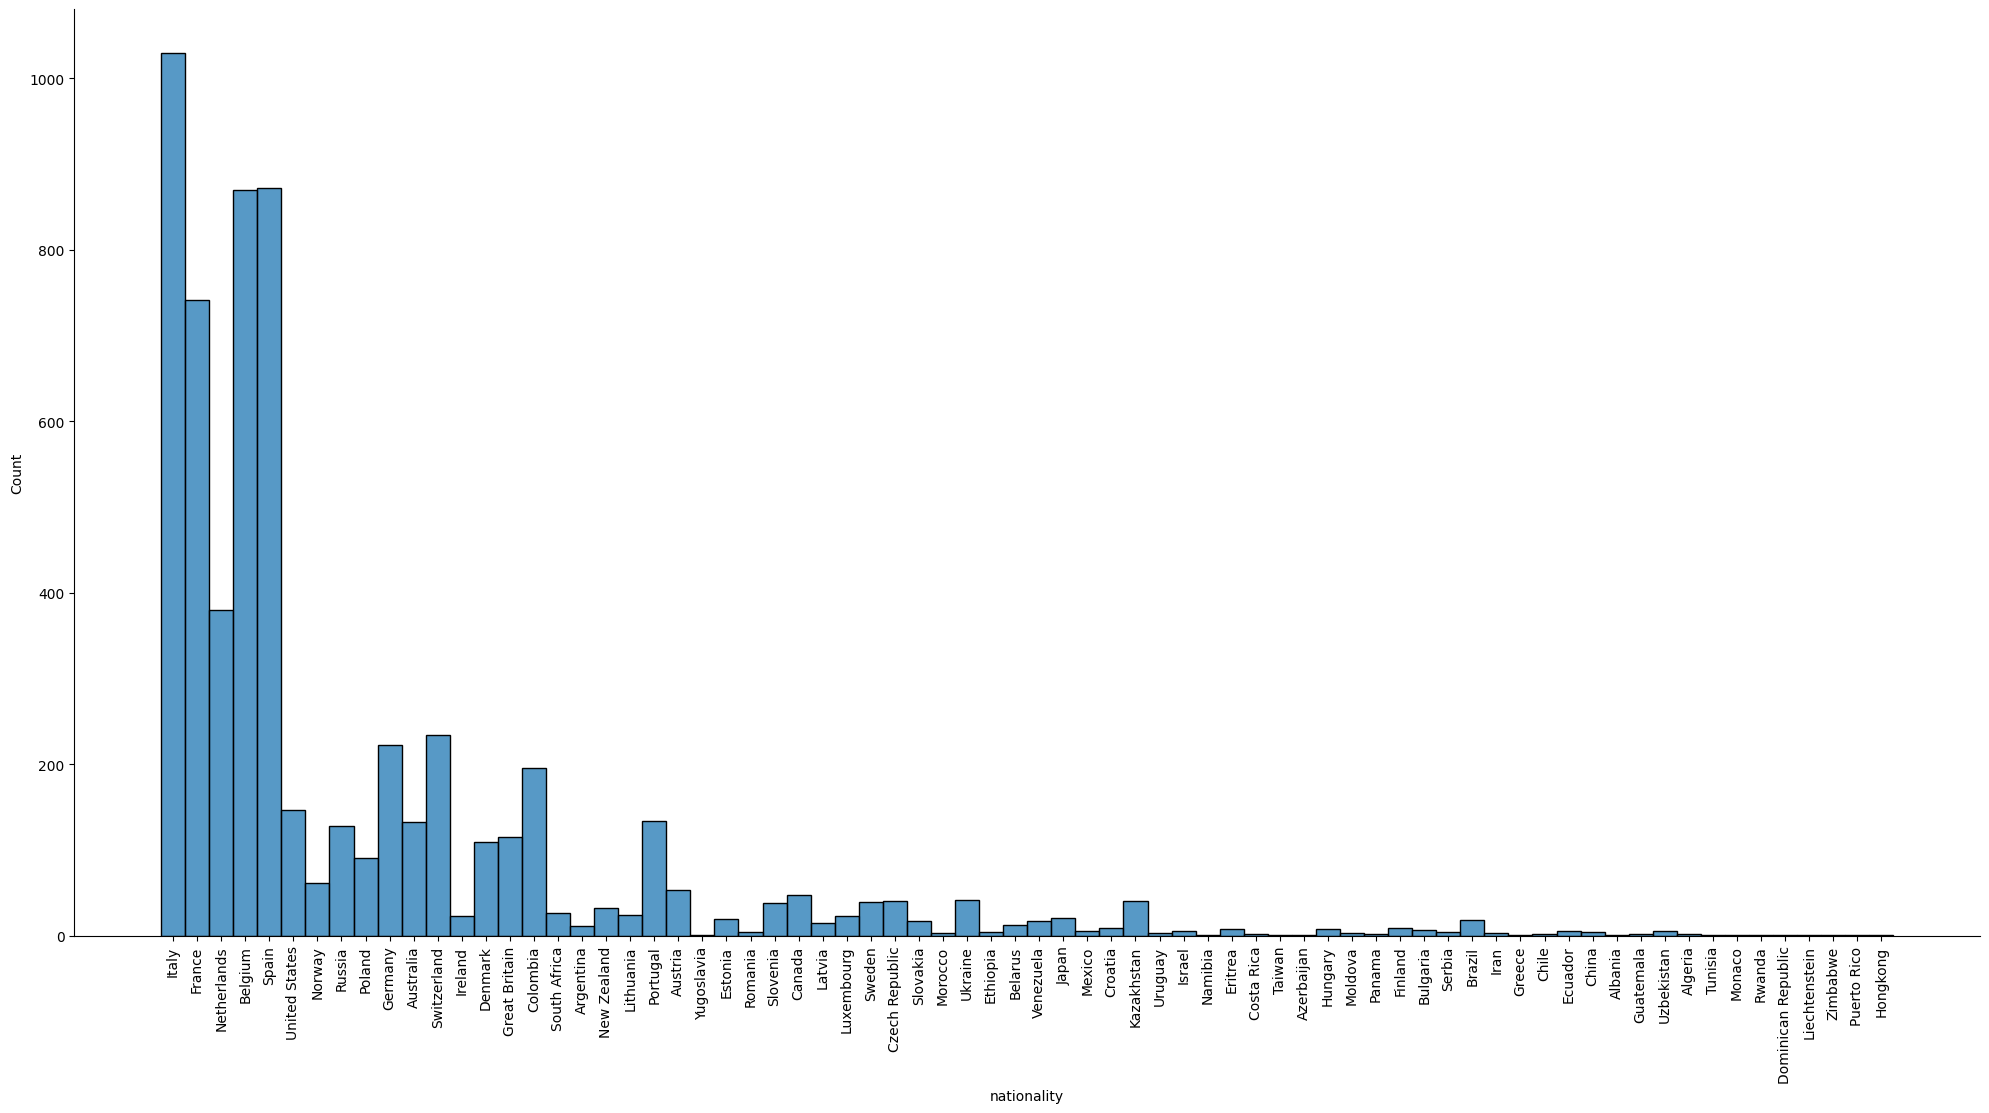

In [22]:
sb.displot(dataset, 
                x="nationality", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['nationality'].unique()),
                height=10,
                aspect=2)
plt.xticks(rotation=90);

Il nostro dataset presenta una maggioranza di dati per nazionalità europee. 

Motivazioni plausibili:
1. Il ciclismo è uno sport storicamente più rilevante in europa;
2. Le gare più importanti si tengono in europa:

    * Atleti più appasionati allo sport sono europei;
    * Gli atleti di nazioni distanti da quelle europee sono meno partecipi alle gare europee;
3. Il nostro dataset presenta dei bias sulle nazionalità dei ciclisti selezionati o sulle gare a cui questi hanno partecipato.

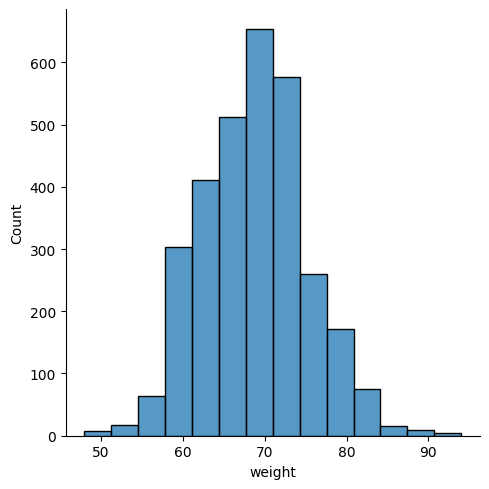

In [23]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

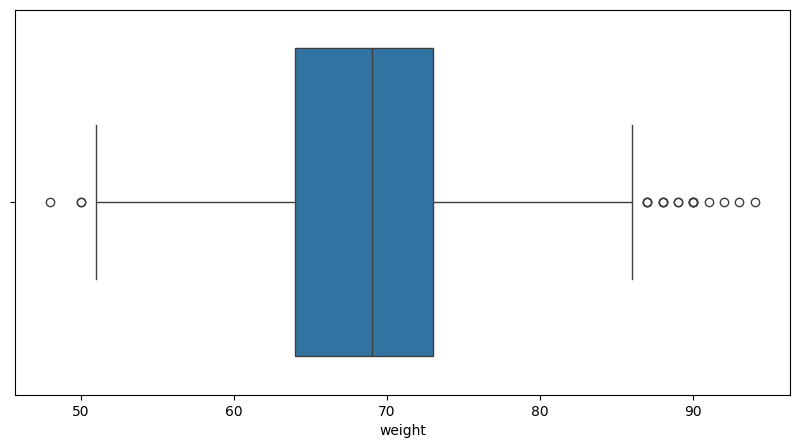

In [24]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='weight', data=dataset)
plt.show()

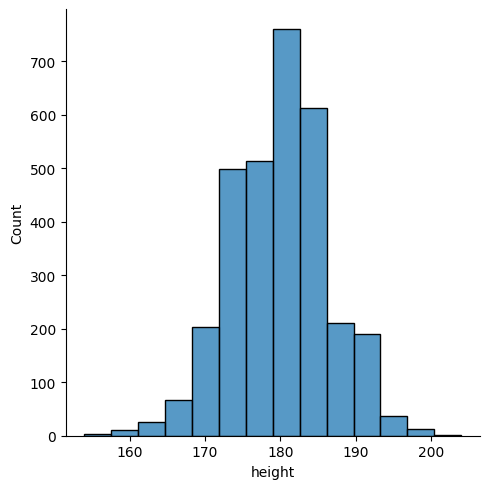

In [25]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

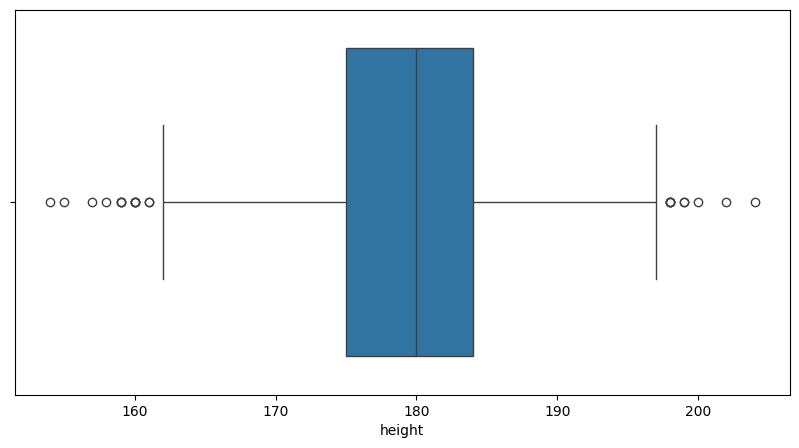

In [26]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='height', data=dataset)
plt.show()

Secondo i dati da noi raccolti da fonti (citare) l'altezza media dei ciclisti dovrebbe essere tra i 175 e i 185 cm con un peso variabile tra i 60 e 70 Kg. I nostri grafici confermano questi dati con le classi maggioritarie per gli attributi localizzate in corrispodnenza di queste medie. Possiamo supporre che la sottorappresentazione dei valori superiori e inferiori non sia dovuta a bias del nostro dataset quanto alla naturale distribuzione statistica del ciclismo

Guardando i grafici precedenti è possibile ricercare la presenza di valori di default che nascondono mancanze nel dataset. Abbiamo rilevato che la distribuzione dei valori è simile a quella che ci potremmo attendere, se ci fosse stato un valore di default la sua frequenza sarebbe stata fuori scala. Da questo momento in poi considereremo questi attributi come privi di valori di default.

## Completeness Analysis
### Analisi dei NaN values

In [27]:
dataset.isnull().sum()

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

In [28]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url            0.000000
name            0.000000
birth_year      0.211933
weight         49.820672
height         48.761004
nationality     0.016303
Name: percent_missing, dtype: float64

In [29]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
dataset[dataset['birth_year'].isnull()]

,_url,name,birth_year,weight,height,nationality
9,scott-davies,Scott Davies,NaN,NaN,NaN,NaN
601,vladimir-malakov,Vladimir Malakov,NaN,NaN,NaN,Russia
894,antonio-zanini,Antonio Zanini,NaN,NaN,NaN,Italy
2408,filippo-simonetti,Filippo Simonetti,NaN,NaN,NaN,Italy
2515,carlos-garcia,Carlos García,NaN,NaN,NaN,Spain
2536,alexandr-osipov,Alexandr Osipov,NaN,NaN,NaN,Russia
3046,nicolai-kosyakov,Nicolai Kosyakov,NaN,NaN,NaN,Russia
3551,nevens-guy,Guy Nevens,NaN,NaN,NaN,Belgium
4142,oscar-pumar,Oscar Pumar,NaN,NaN,NaN,Venezuela
4384,javier-luquin,Javier Luquin,NaN,NaN,NaN,Spain


## Imputation

### Tentativo di imputazione manuale delle date di nascita mancanti sfruttando i dati del dataset 'races.csv'

I ciclisti nel dataset 'cyclist.csv' hanno età NaN in ogni record del dataset 'races.csv'

In [30]:
# cyclist
tmp_df = races[races['cyclist'].isin(missing_birthyear)]
tmp_df[tmp_df['cyclist_age'].notnull()]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


Abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online supportate da confronti diretti con altri dati presenti nel dataset 'races.csv'

Una volta identificato un ciclista con alta probabilità abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [31]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies che era già stato correttamente identificato nella fase precedente, grazie a cui abbiamo rivenuto anche questa informazione

In [32]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

In [33]:
#TODO usare info età corse per correggere alla perfezione
dataset['birth_year'] = dataset['birth_year'].fillna(dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

In [34]:
dataset.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        0
weight         3056
height         2991
nationality       0
dtype: int64

### Imputation per altezza e peso

La nostra ipotesi di partenza è che altezza peso e nazionalità siano correlati. Desidereremmo sfruttare questa informazione per eseguire una imputazione di vicinanza nei record incompleti. 

Per poter procedere con questa strategia è essenziale stabilire le reali correlazioni tra questi attributi (confermando o smentendo quelle attese o scoprendone di nuove)

In [35]:
dataset[dataset['height'].isnull() & dataset['weight'].isnull()]

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
6,willy-moonen,Willy Moonen,1947.0,NaN,NaN,Belgium
9,scott-davies,Scott Davies,1995.0,NaN,NaN,Great Britain
10,stian-remme,Stian Remme,1982.0,NaN,NaN,Norway
13,evgueny-anachkine,Evgueny Anachkine,1970.0,NaN,NaN,Russia
...,...,...,...,...,...,...
6123,francisque-teyssier,Francisque Teyssier,1969.0,NaN,NaN,France
6127,hendrik-van-dyck,Hendrik Van Dyck,1974.0,NaN,NaN,Belgium
6128,francisco-jose-pacheco,Francisco José Pacheco,1982.0,NaN,NaN,Spain
6129,juan-jose-martinez-diaz,Juan José Martínez,1966.0,NaN,NaN,Spain


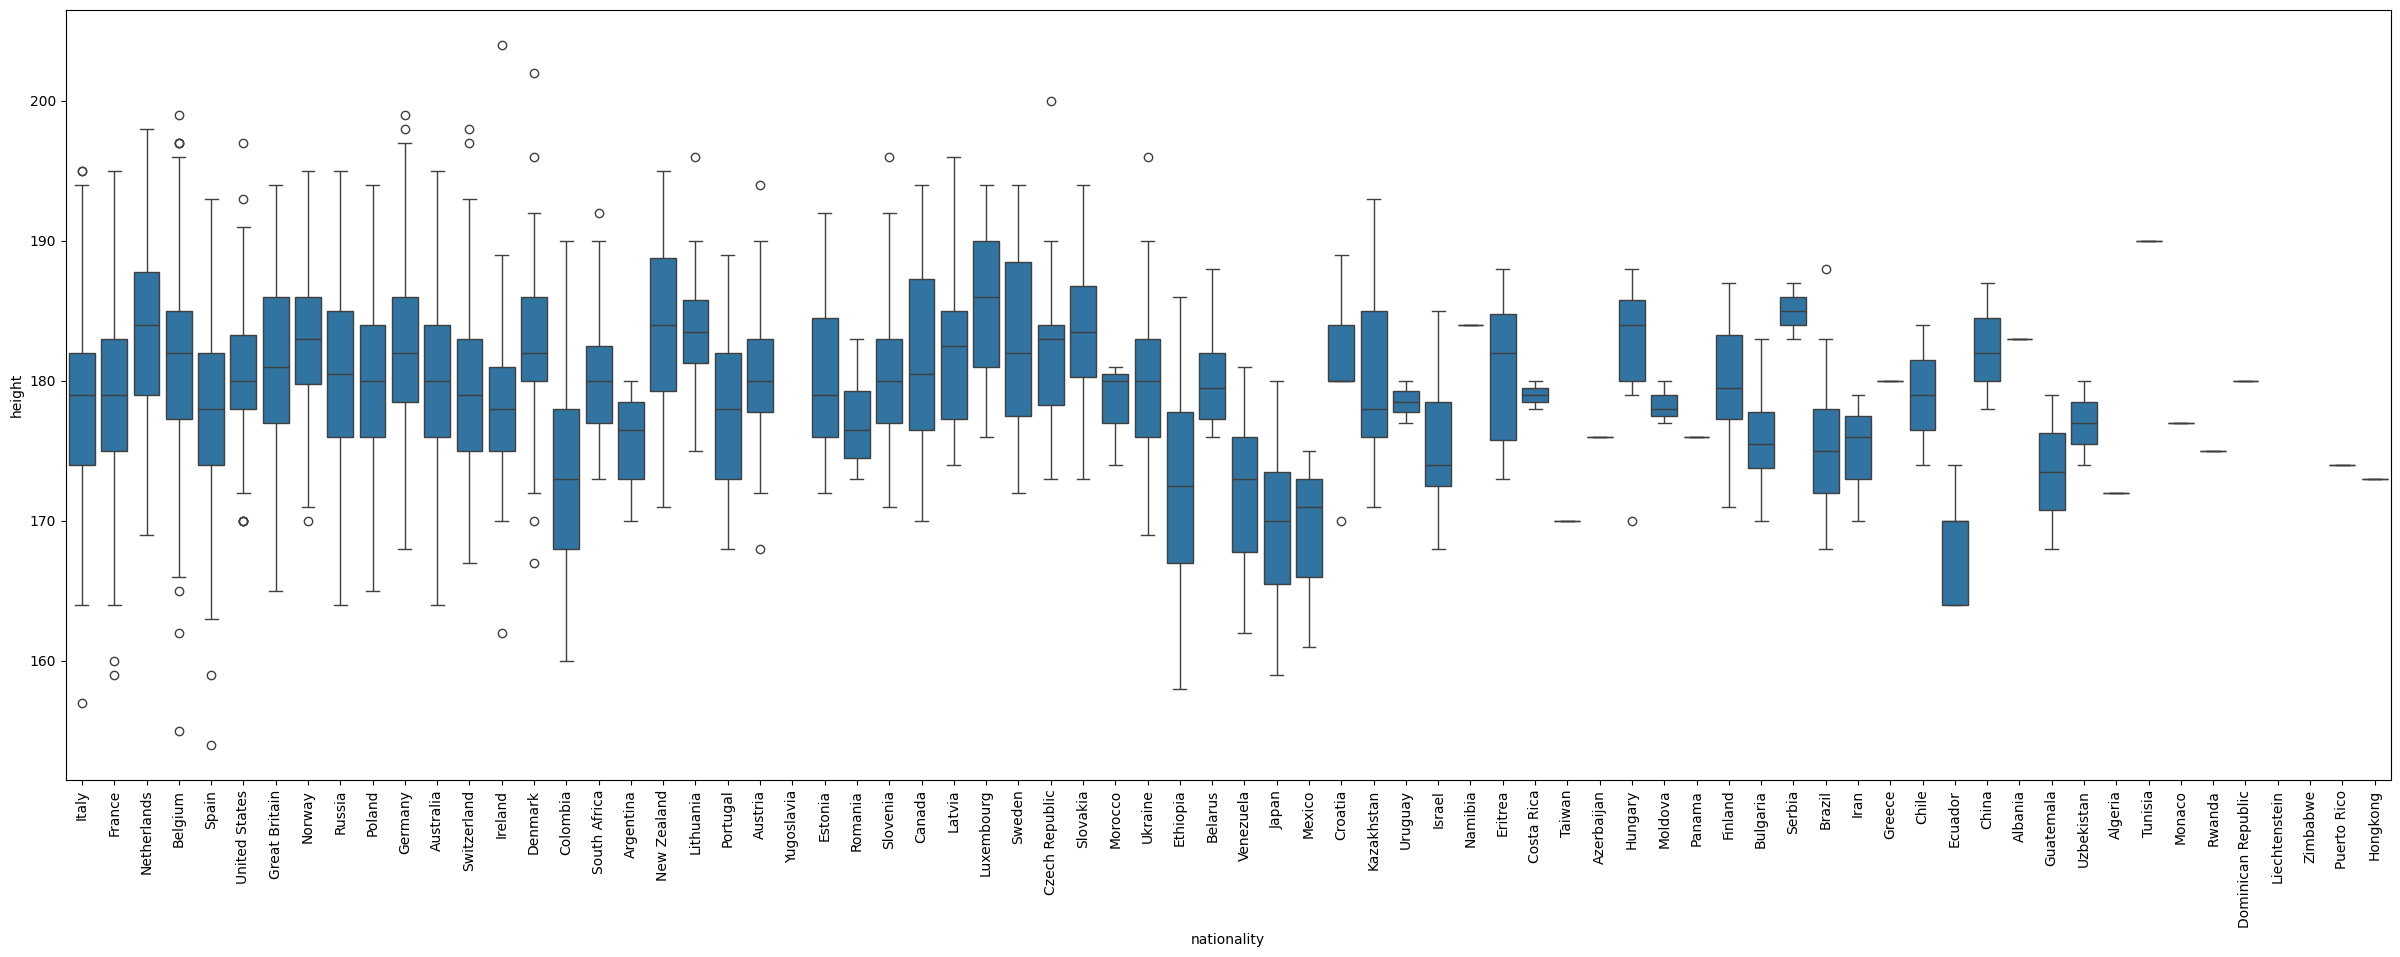

In [36]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='height', data=dataset)
plt.xticks(rotation=90);
plt.show()

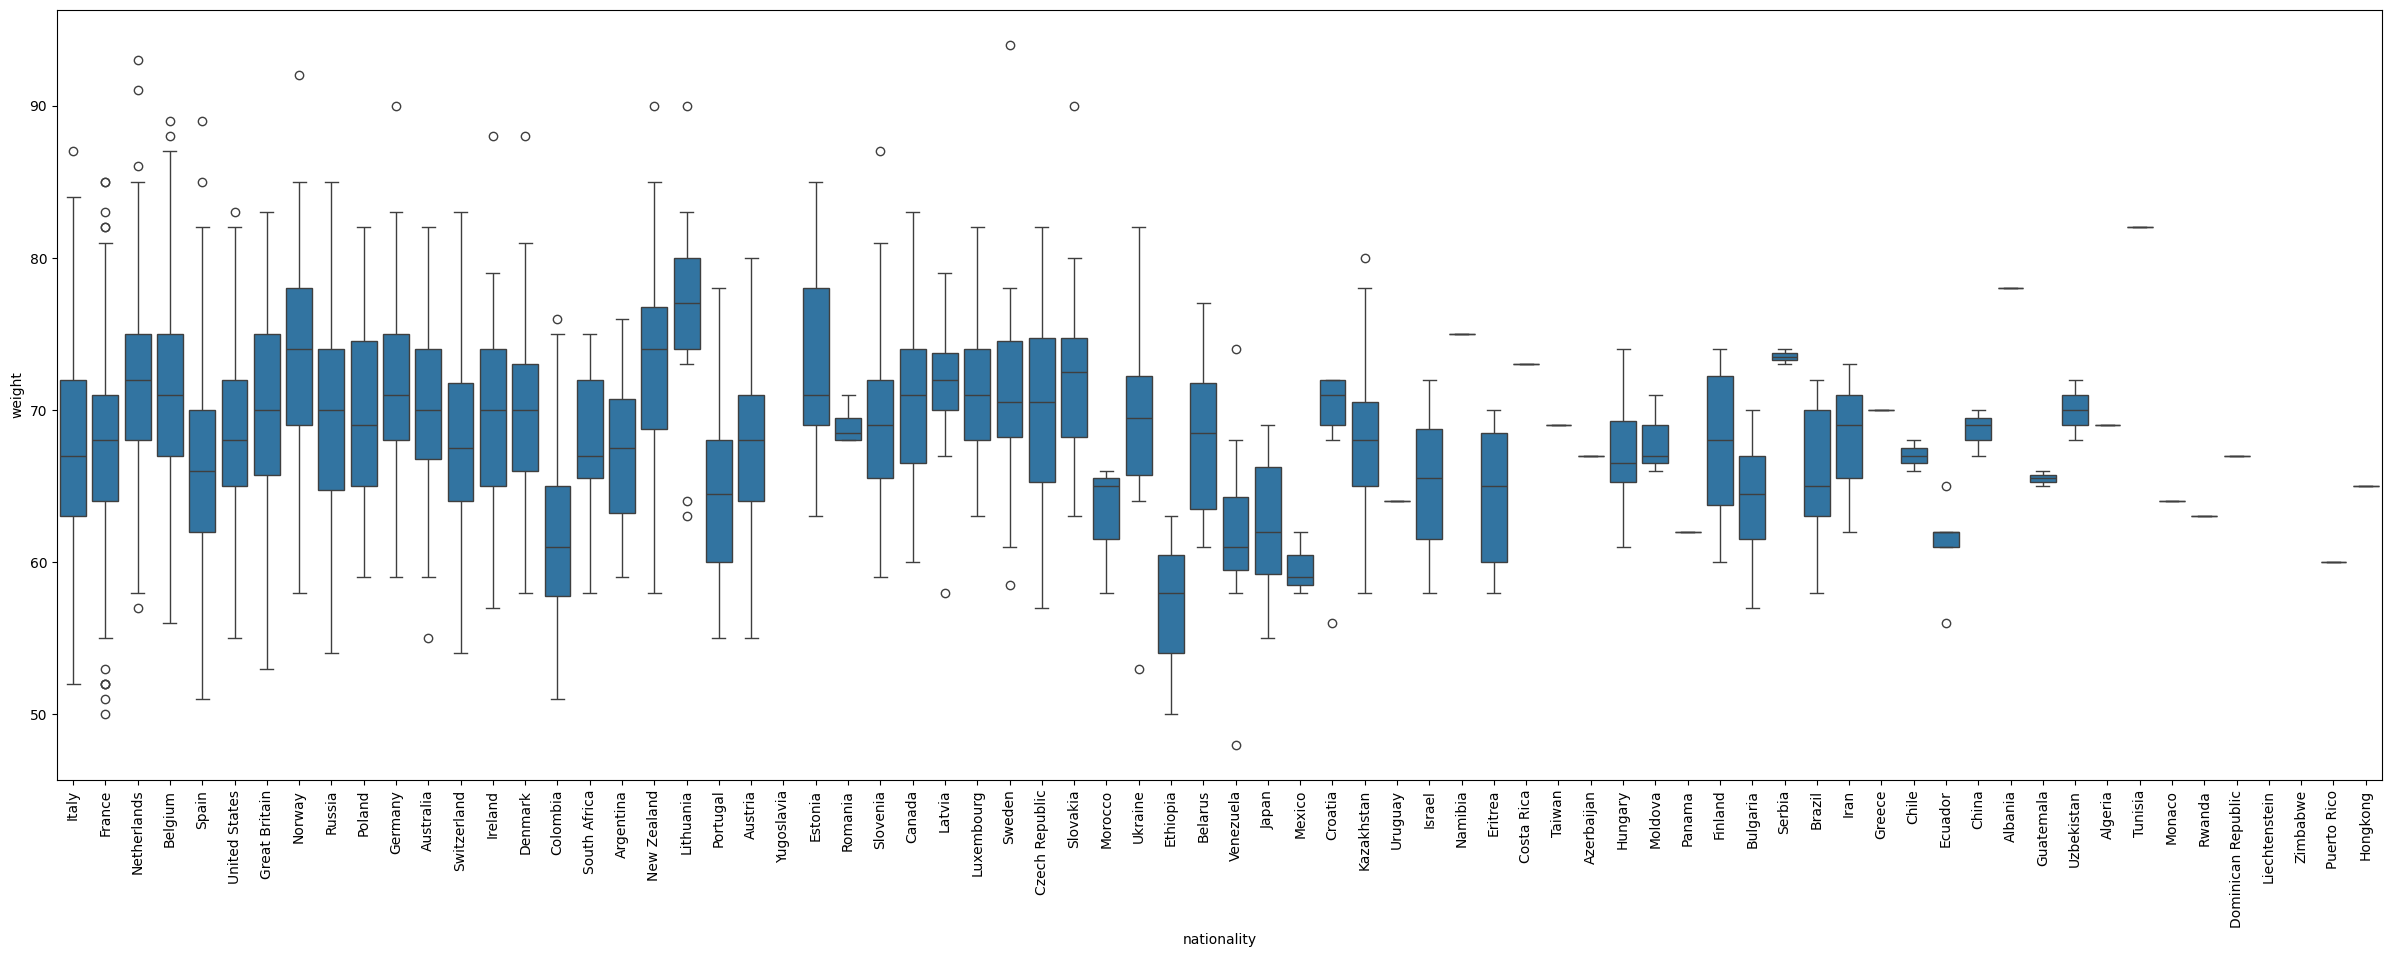

In [37]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='weight', data=dataset)
plt.xticks(rotation=90);
plt.show()

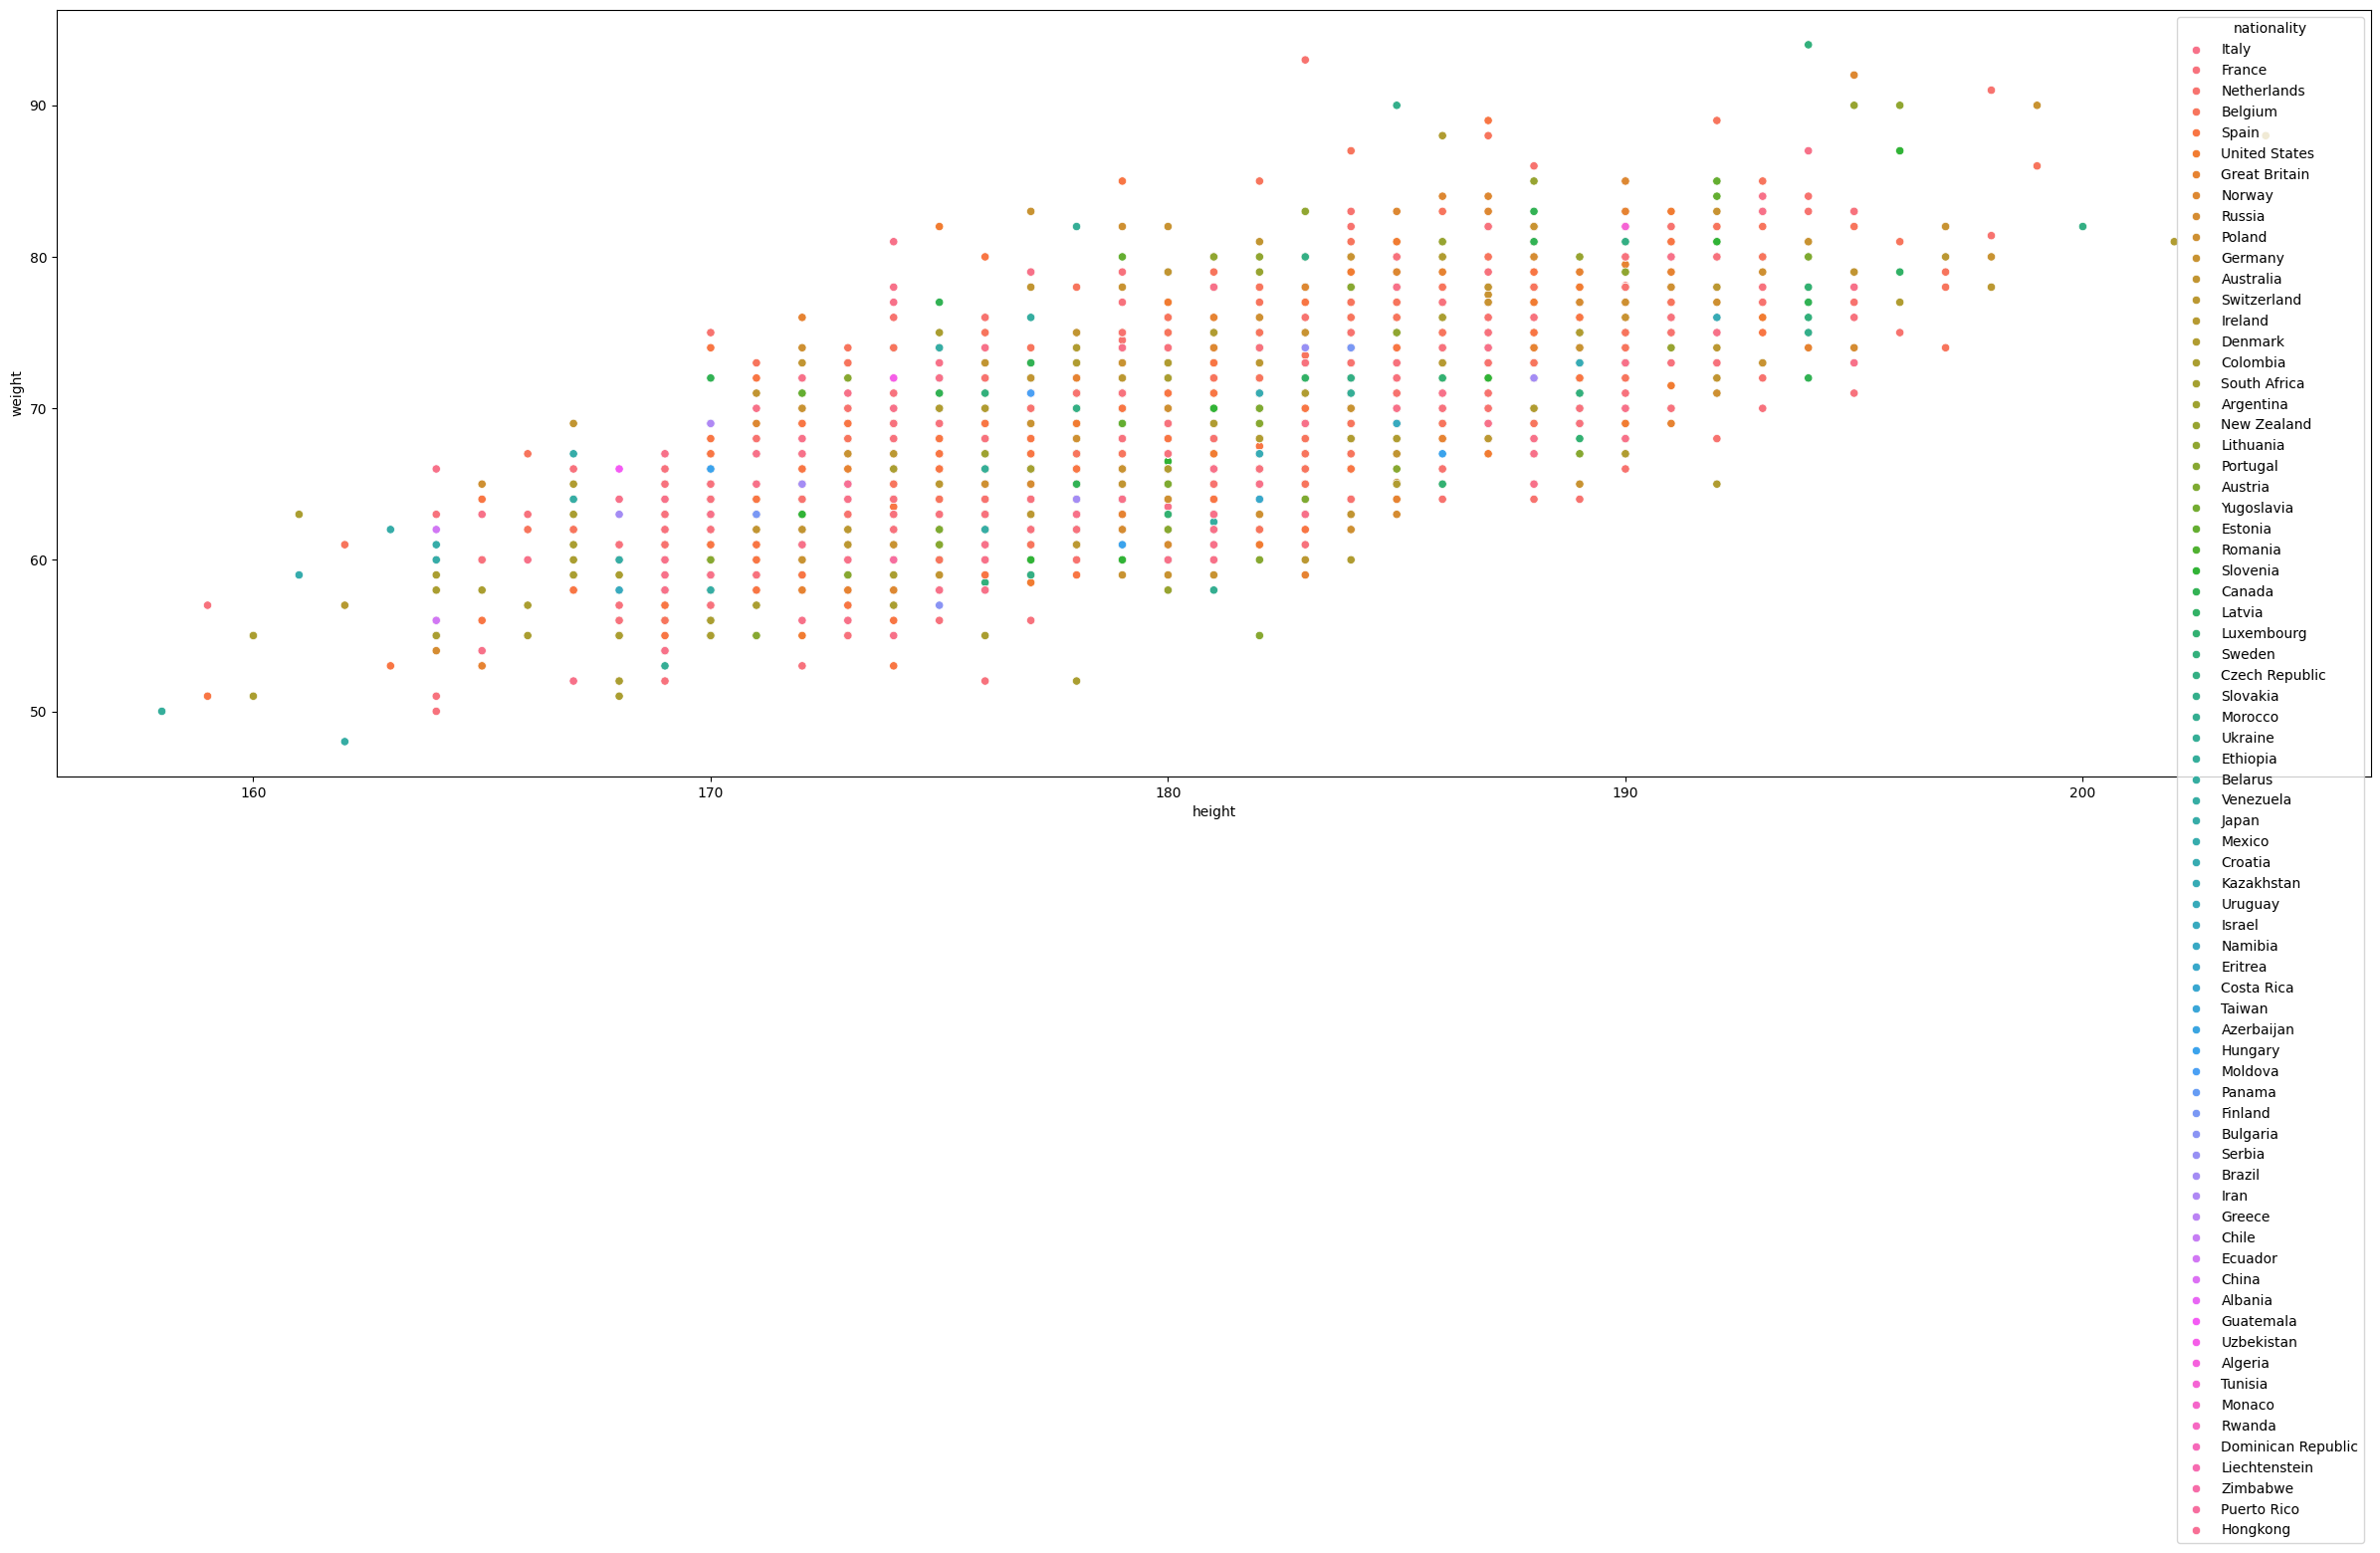

In [38]:
plt.figure(figsize=(30, 10))
sb.scatterplot(x='height', y='weight', data=dataset, hue='nationality')
plt.show()

Dall'analisi qualitativa di questo boxplot emerge che distinguendo per nazionalità le distribuzioni probabilistiche degli attributi altezza e peso non siano particolarmente diversificate. Le poche differenze che possiamo notare (ad esempio Ecuador rispetto a Cina) non sono supportate da una sufficiente quantità di record (confronto tra 5 e 4 ciclisti).

Il tipo di imputazione che abbiamo ipotizzato in precedenza non sarebbe quindi sufficientemente efficace e potrebbe anzi produrre bias "peggiori" rispetto ad altri tipi di imputazione più semplce (come quella statistica). Procederemmo quindi sostituendo le altezze e i pesi mancanti con un'estrazione di valori casuali dalla distribuzione globale degli attributi

Obiettivo, sostituire i valori mantenendo la distribuzione

In [39]:
N = len(dataset[dataset['height'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

dataset['height_discretized'] = pd.cut(dataset['height'], bins=bins, labels=[i for i in range(1, bins+1)])

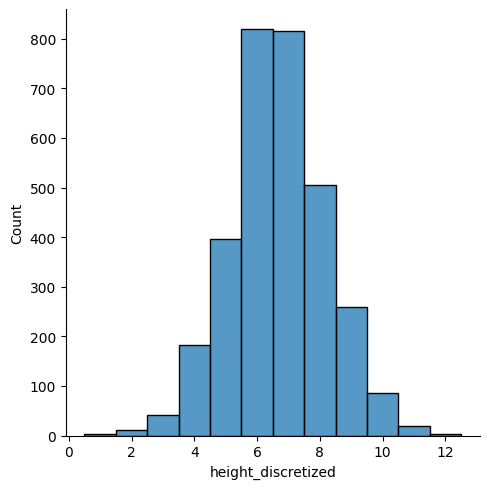

In [40]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

In [41]:
dataset['height_discretized'].value_counts(normalize=True).sort_index()
# probabilità di ogni classe di altezza

height_discretized
1     0.001273
2     0.003818
3     0.013045
4     0.058225
5     0.125994
6     0.260579
7     0.259625
8     0.160675
9     0.082405
10    0.027362
11    0.006045
12    0.000955
Name: proportion, dtype: float64

In [42]:
probabilities = dataset['height_discretized'].value_counts(normalize=True).sort_index().to_list()
classes = [i for i in range(1, bins+1)] # the values to be extracted
random_height_discretized = random.choices(classes, weights=probabilities, k=len(dataset[dataset['height_discretized'].isnull()]))
nan_indices = dataset[dataset['height_discretized'].isna()]['height_discretized'].index

for idx, val in zip(nan_indices, random_height_discretized):
    dataset.at[idx, 'height_discretized'] = val

In [43]:
dataset['height_discretized'].isnull().sum()

np.int64(0)

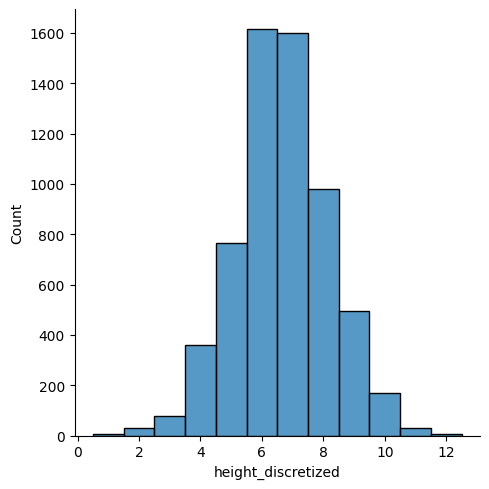

In [44]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

Dopo aver sostituito i valori NaN dell'attributo "height_discretized" controlliamo che la distribuzione rimanga pressochè simile a quella originale

In [45]:
mean_heights = dataset[['height', 'height_discretized']].groupby(by='height_discretized', observed=True).mean()['height'] # compute the mean height for each heigt_discretized

def return_mean_height(row):
    return mean_heights[mean_heights.index == row['height_discretized']].iloc[0]

height_to_substitue = dataset[dataset['height'].isnull() & dataset['weight'].isnull()].apply(return_mean_height, axis=1)
dataset.loc[height_to_substitue.index, 'height'] = height_to_substitue.values

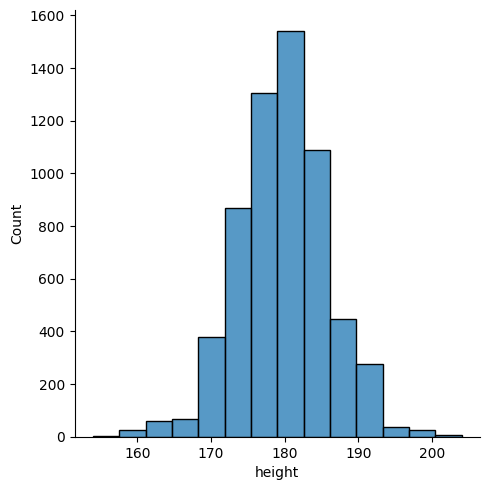

In [46]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

solito controllo della distribuzione per verificare che sia pressoché simile a quella originale

In [47]:
imputer = KNNImputer(n_neighbors=6) #TODO: controllare bene se vada bene questo valore di n_neighbors

imputed_values = imputer.fit_transform(dataset[['height', 'weight']])
dataset[['height', 'weight']] = imputed_values

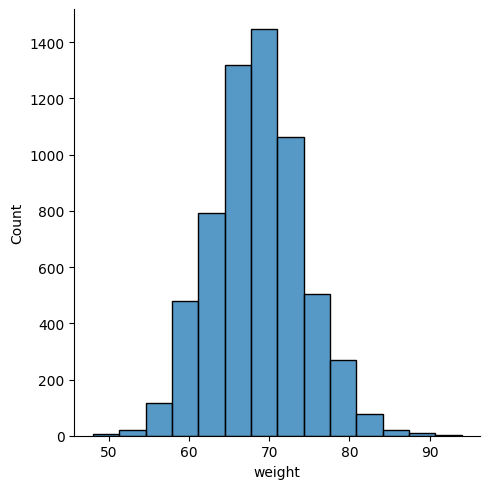

In [48]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

per sostituire i valori NaN della feature "weight" abbiamo usato il KNNImputer, utilizzando un numero di vicini che permettesse di mantenere la distribuzione originale